# Titanic - Machine Learning from Disaster

[Start here](https://www.kaggle.com/c/titanic/overview)! Predict survival on the Titanic and get familiar with ML basics

# 0. Import Packages

In [230]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [231]:
# Various paths
DATA_DIR = '../data/titanic/'
TRAIN_PATH = DATA_DIR + 'train.csv'
TEST_PATH = DATA_DIR + 'test.csv'
SAMPLE_SUBMISSION_PATH = DATA_DIR + 'gender_submission.csv'

# 1. Data Exploration

## 1.1 Training Data Analysis

In [232]:
train = pd.read_csv(TRAIN_PATH)

In [233]:
train.shape

(891, 12)

In [234]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [235]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [236]:
train.Survived.value_counts().to_dict()

{0: 549, 1: 342}

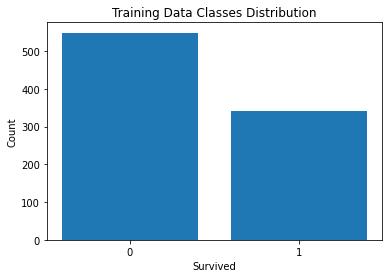

In [237]:
def plot_class_distributions(train_data: pd.DataFrame, column_name: str):
    counts = train_data[column_name].value_counts().to_dict()
    x_arr = [0, 1]
    y_arr = list(map(lambda c: counts.get(c, 0), x_arr))
    
    fig, ax = plt.subplots()
    ax.bar(x_arr, y_arr)
    ax.set_xlabel('Survived')
    ax.set_ylabel('Count')
    ax.set_xticks(x_arr)
    ax.set_title('Training Data Classes Distribution')
    
    plt.show()

plot_class_distributions(train, 'Survived')

## 1.2 Prepare Datasets

Data cleaning & pre-processing.

In [238]:
# # Drop some columns that may not have impact on the value of "Survived"
# train_df = train.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
# train_df.head()

In [239]:
# train_df.shape

In [240]:
# # Check for NANs
# # ref: https://datatofish.com/check-nan-pandas-dataframe/
# train_df.isnull().sum()

As we have NANs in our dataset, some mechanisms should be applied to deal with this case.

Ref: https://blog.csdn.net/weixin_44363807/article/details/91449119

In [241]:
# # Fill NANs
# train_df['Age'] = train_df['Age'].fillna(train_df['Age'].mean())

In [242]:
# train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])

In [243]:
# train_df.isnull().sum()

In [244]:
# Pre-processing
def pre_processing(df):
    # Mappings
    EMBARKATION_PORT = {
        'S': 1,
        'C': 2,
        'Q': 3,
    }
    SEX = {
        'male': 0,
        'female': 1,
    }
    
    df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
    
    # Fill NANs
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
    
    df['Sex']= df['Sex'].apply(lambda x: SEX.get(x, 0))
    df['Embarked'] = df['Embarked'].apply(lambda x: EMBARKATION_PORT.get(x, 0))
    df['Age'] = (df['Age'] - df['Age'].min()) / (df['Age'].max() - df['Age'].min())  # Min-max scaling
    df['Fare'] = (df['Fare'] - df['Fare'].min()) / (df['Fare'].max() - df['Fare'].min())  # Min-max scaling
    
    return df

In [245]:
train_df = pre_processing(train)

In [246]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,0.271174,1,0,0.014151,1
1,1,1,1,0.472229,1,0,0.139136,2
2,1,3,1,0.321438,0,0,0.015469,1
3,1,1,1,0.434531,1,0,0.103644,1
4,0,3,0,0.434531,0,0,0.015713,1


In [247]:
X, y = train_df.drop(columns=['Survived']), train_df['Survived']

# Train & Dev dataset splitting
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=1)

In [248]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_dev:', X_dev.shape)
print('y_dev:', y_dev.shape)

X_train: (712, 7)
y_train: (712,)
X_dev: (179, 7)
y_dev: (179,)


In [249]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
301,3,0,0.367921,2,0,0.045381,3
309,1,1,0.371701,0,0,0.111118,2
516,2,1,0.421965,0,0,0.020495,1
120,2,0,0.258608,2,0,0.143462,1
570,2,0,0.773813,0,0,0.020495,1


# 2.  Model Selection

## 2.1 Logistic Regression 

In [250]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [251]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_model.score(X_train, y_train)

0.8075842696629213

In [252]:
y_pred_train = lr_model.predict(X_train)
y_true_train = y_train
target_names = ['class 0', 'class 1']
print(classification_report(y_true_train, y_pred_train, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.83      0.87      0.85       443
     class 1       0.77      0.70      0.73       269

    accuracy                           0.81       712
   macro avg       0.80      0.79      0.79       712
weighted avg       0.81      0.81      0.81       712



In [253]:
y_pred_dev = lr_model.predict(X_dev)
y_true_dev = y_dev
target_names = ['class 0', 'class 1']
print(classification_report(y_true_dev, y_pred_dev, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.81      0.87      0.84       106
     class 1       0.78      0.70      0.74        73

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



**Conclusion:**

Logistic Regression model with default hyper-parameters gives the accuracies:

- Train Set: 0.81
- Dev Set: 0.80

## 2.2 Decision Tree

In [ ]:
from sklearn import tree

In [ ]:
dt_model = tree.DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
lr_model.score(X_train, y_train)

In [ ]:
y_pred_train = lr_model.predict(X_train)
y_true_train = y_train
target_names = ['class 0', 'class 1']
print(classification_report(y_true_train, y_pred_train, target_names=target_names))

In [ ]:
y_pred_dev = lr_model.predict(X_dev)
y_true_dev = y_dev
target_names = ['class 0', 'class 1']
print(classification_report(y_true_dev, y_pred_dev, target_names=target_names))

**Conclusion:**

Decision Tree model with default hyper-parameters gives the accuracies:

- Train Set: 0.81
- Dev Set: 0.80

## 2.3 SVM

In [ ]:
from sklearn import svm

In [ ]:
svm_model = svm.SVC()
svm_model.fit(X_train, y_train)
svm_model.score(X_train, y_train)

In [ ]:
y_pred_train = lr_model.predict(X_train)
y_true_train = y_train
target_names = ['class 0', 'class 1']
print(classification_report(y_true_train, y_pred_train, target_names=target_names))

In [163]:
y_pred_dev = lr_model.predict(X_dev)
y_true_dev = y_dev
target_names = ['class 0', 'class 1']
print(classification_report(y_true_dev, y_pred_dev, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.81      0.87      0.84       106
     class 1       0.78      0.70      0.74        73

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



**Conclusion:**

SVM model with default hyper-parameters gives the accuracies:

- Train Set: 0.81
- Dev Set: 0.80

## 2.4 Neural Networks

In [164]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers as tfl

In [194]:
def build_model():
    nn_model = keras.Sequential(
        [
            tfl.Input(shape=(X_train.shape[1],), dtype='float32'),
            tfl.Dense(units=20, activation='relu', name='layer1'),
            tfl.Dense(units=1, activation='sigmoid', name='layer2'),
        ]
    )

    nn_model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=0.02),
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )

    nn_model.summary()
    
    return nn_model

In [195]:
nn_model = build_model()
history = nn_model.fit(X_train, y_train, epochs=10000)

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 20)                160       
_________________________________________________________________
layer2 (Dense)               (None, 1)                 21        
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.5849 - accuracy: 0.6896
Epoch 2/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.5668 - accuracy: 0.7233
Epoch 3/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.5533 - accuracy: 0.7430
Epoch 4/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.5411 - accuracy: 0.7584
Epoch 5/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.5298 - accuracy: 0.7612
Epoch 6/1000

23/23 [==============================] - 0s 2ms/step - loss: 0.4327 - accuracy: 0.8062
Epoch 76/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.4327 - accuracy: 0.8006
Epoch 77/10000
23/23 [==============================] - 0s 4ms/step - loss: 0.4325 - accuracy: 0.8048
Epoch 78/10000
23/23 [==============================] - 0s 4ms/step - loss: 0.4334 - accuracy: 0.8076
Epoch 79/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.4336 - accuracy: 0.8090
Epoch 80/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.4327 - accuracy: 0.8048
Epoch 81/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.4338 - accuracy: 0.8048
Epoch 82/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4318 - accuracy: 0.8034
Epoch 83/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4318 - accuracy: 0.8034
Epoch 84/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4329 - accuracy: 0.

23/23 [==============================] - 0s 2ms/step - loss: 0.4269 - accuracy: 0.8146
Epoch 155/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.4265 - accuracy: 0.8118
Epoch 156/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.4275 - accuracy: 0.8076
Epoch 157/10000
23/23 [==============================] - 0s 4ms/step - loss: 0.4261 - accuracy: 0.8104
Epoch 158/10000
23/23 [==============================] - 0s 4ms/step - loss: 0.4264 - accuracy: 0.8104
Epoch 159/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.4257 - accuracy: 0.8174
Epoch 160/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4252 - accuracy: 0.8188
Epoch 161/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4279 - accuracy: 0.8132
Epoch 162/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4253 - accuracy: 0.8118
Epoch 163/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4251 - acc

23/23 [==============================] - 0s 3ms/step - loss: 0.4207 - accuracy: 0.8132
Epoch 234/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4213 - accuracy: 0.8160
Epoch 235/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4228 - accuracy: 0.8174
Epoch 236/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.4216 - accuracy: 0.8118
Epoch 237/10000
23/23 [==============================] - 1s 24ms/step - loss: 0.4212 - accuracy: 0.8188
Epoch 238/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4212 - accuracy: 0.8216
Epoch 239/10000
23/23 [==============================] - 0s 989us/step - loss: 0.4216 - accuracy: 0.8174
Epoch 240/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.4215 - accuracy: 0.8160
Epoch 241/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4226 - accuracy: 0.8160
Epoch 242/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.4206 - 

23/23 [==============================] - 0s 3ms/step - loss: 0.4190 - accuracy: 0.8244
Epoch 313/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.4189 - accuracy: 0.8216: 0s - loss: 0.4110 - accuracy: 0.82
Epoch 314/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.4177 - accuracy: 0.8230
Epoch 315/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4176 - accuracy: 0.8272
Epoch 316/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4184 - accuracy: 0.8343
Epoch 317/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4184 - accuracy: 0.8230
Epoch 318/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4178 - accuracy: 0.8287
Epoch 319/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4176 - accuracy: 0.8301
Epoch 320/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4173 - accuracy: 0.8287
Epoch 321/10000
23/23 [==============================

23/23 [==============================] - 0s 1ms/step - loss: 0.4116 - accuracy: 0.8244
Epoch 392/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.4129 - accuracy: 0.8287
Epoch 393/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4133 - accuracy: 0.8287
Epoch 394/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4132 - accuracy: 0.8230
Epoch 395/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.4144 - accuracy: 0.8244
Epoch 396/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4123 - accuracy: 0.8258
Epoch 397/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4147 - accuracy: 0.8272
Epoch 398/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4121 - accuracy: 0.8301
Epoch 399/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4124 - accuracy: 0.8272
Epoch 400/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4128 - acc

23/23 [==============================] - 0s 3ms/step - loss: 0.4094 - accuracy: 0.8301
Epoch 471/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.4103 - accuracy: 0.8301
Epoch 472/10000
23/23 [==============================] - 0s 4ms/step - loss: 0.4094 - accuracy: 0.8315
Epoch 473/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4119 - accuracy: 0.8301
Epoch 474/10000
23/23 [==============================] - 0s 4ms/step - loss: 0.4092 - accuracy: 0.8357
Epoch 475/10000
23/23 [==============================] - 0s 4ms/step - loss: 0.4102 - accuracy: 0.8258
Epoch 476/10000
23/23 [==============================] - 0s 6ms/step - loss: 0.4096 - accuracy: 0.8301
Epoch 477/10000
23/23 [==============================] - 0s 5ms/step - loss: 0.4090 - accuracy: 0.8343
Epoch 478/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.4105 - accuracy: 0.8258
Epoch 479/10000
23/23 [==============================] - 0s 5ms/step - loss: 0.4106 - acc

23/23 [==============================] - 0s 1ms/step - loss: 0.4082 - accuracy: 0.8272
Epoch 550/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.4076 - accuracy: 0.8301
Epoch 551/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4075 - accuracy: 0.8287
Epoch 552/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.4085 - accuracy: 0.8301
Epoch 553/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4081 - accuracy: 0.8315
Epoch 554/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.4092 - accuracy: 0.8315
Epoch 555/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4088 - accuracy: 0.8301
Epoch 556/10000
23/23 [==============================] - 0s 927us/step - loss: 0.4076 - accuracy: 0.8371
Epoch 557/10000
23/23 [==============================] - 0s 987us/step - loss: 0.4076 - accuracy: 0.8258
Epoch 558/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4065 -

23/23 [==============================] - 0s 2ms/step - loss: 0.4065 - accuracy: 0.8357
Epoch 629/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.4054 - accuracy: 0.8329
Epoch 630/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.4052 - accuracy: 0.8301
Epoch 631/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4062 - accuracy: 0.8287
Epoch 632/10000
23/23 [==============================] - 0s 957us/step - loss: 0.4067 - accuracy: 0.8301
Epoch 633/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.4047 - accuracy: 0.8371
Epoch 634/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4057 - accuracy: 0.8329
Epoch 635/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4074 - accuracy: 0.8357
Epoch 636/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.4057 - accuracy: 0.8329
Epoch 637/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4058 - a

23/23 [==============================] - 0s 2ms/step - loss: 0.4058 - accuracy: 0.8287
Epoch 708/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.4027 - accuracy: 0.8371
Epoch 709/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4045 - accuracy: 0.8287
Epoch 710/10000
23/23 [==============================] - 0s 925us/step - loss: 0.4022 - accuracy: 0.8385
Epoch 711/10000
23/23 [==============================] - 0s 941us/step - loss: 0.4050 - accuracy: 0.8357
Epoch 712/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4044 - accuracy: 0.8357
Epoch 713/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.4050 - accuracy: 0.8385
Epoch 714/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4049 - accuracy: 0.8329
Epoch 715/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.4043 - accuracy: 0.8357
Epoch 716/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.4031 -

23/23 [==============================] - 0s 924us/step - loss: 0.4011 - accuracy: 0.8343
Epoch 787/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.4025 - accuracy: 0.8343
Epoch 788/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.4019 - accuracy: 0.8357
Epoch 789/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4026 - accuracy: 0.8357
Epoch 790/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4018 - accuracy: 0.8343
Epoch 791/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4019 - accuracy: 0.8357
Epoch 792/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4014 - accuracy: 0.8371
Epoch 793/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.4031 - accuracy: 0.8385
Epoch 794/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4014 - accuracy: 0.8301
Epoch 795/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4018 - a

23/23 [==============================] - 0s 2ms/step - loss: 0.4010 - accuracy: 0.8357
Epoch 866/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3994 - accuracy: 0.8371
Epoch 867/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4005 - accuracy: 0.8427
Epoch 868/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3994 - accuracy: 0.8343
Epoch 869/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4012 - accuracy: 0.8385
Epoch 870/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4007 - accuracy: 0.8399
Epoch 871/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.4003 - accuracy: 0.8441
Epoch 872/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3979 - accuracy: 0.8371
Epoch 873/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4005 - accuracy: 0.8343
Epoch 874/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.4001 - acc

23/23 [==============================] - 0s 2ms/step - loss: 0.3968 - accuracy: 0.8399
Epoch 945/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3975 - accuracy: 0.8399
Epoch 946/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3970 - accuracy: 0.8357
Epoch 947/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3991 - accuracy: 0.8413
Epoch 948/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3981 - accuracy: 0.8441
Epoch 949/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3981 - accuracy: 0.8343
Epoch 950/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3983 - accuracy: 0.8385
Epoch 951/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3970 - accuracy: 0.8399
Epoch 952/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3968 - accuracy: 0.8399
Epoch 953/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3978 - acc

23/23 [==============================] - 0s 2ms/step - loss: 0.3954 - accuracy: 0.8357
Epoch 1024/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3954 - accuracy: 0.8329
Epoch 1025/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3959 - accuracy: 0.8385
Epoch 1026/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3957 - accuracy: 0.8329
Epoch 1027/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3970 - accuracy: 0.8413
Epoch 1028/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3945 - accuracy: 0.8413
Epoch 1029/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3958 - accuracy: 0.8357
Epoch 1030/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3943 - accuracy: 0.8385
Epoch 1031/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3951 - accuracy: 0.8357
Epoch 1032/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3925 - accuracy: 0.8329
Epoch 1102/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3941 - accuracy: 0.8385
Epoch 1103/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3933 - accuracy: 0.8399
Epoch 1104/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3943 - accuracy: 0.8427
Epoch 1105/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3923 - accuracy: 0.8371
Epoch 1106/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3935 - accuracy: 0.8427
Epoch 1107/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3954 - accuracy: 0.8371
Epoch 1108/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3922 - accuracy: 0.8301
Epoch 1109/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3926 - accuracy: 0.8455
Epoch 1110/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 1ms/step - loss: 0.3921 - accuracy: 0.8272
Epoch 1180/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3924 - accuracy: 0.8399
Epoch 1181/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3911 - accuracy: 0.8427
Epoch 1182/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3899 - accuracy: 0.8427
Epoch 1183/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3916 - accuracy: 0.8343
Epoch 1184/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3917 - accuracy: 0.8371
Epoch 1185/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3905 - accuracy: 0.8371
Epoch 1186/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3916 - accuracy: 0.8399
Epoch 1187/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3912 - accuracy: 0.8371
Epoch 1188/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3893 - accuracy: 0.8469
Epoch 1258/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3877 - accuracy: 0.8385
Epoch 1259/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3868 - accuracy: 0.8413
Epoch 1260/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3894 - accuracy: 0.8427
Epoch 1261/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3895 - accuracy: 0.8371
Epoch 1262/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3893 - accuracy: 0.8413
Epoch 1263/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3877 - accuracy: 0.8427
Epoch 1264/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3882 - accuracy: 0.8427
Epoch 1265/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3886 - accuracy: 0.8399
Epoch 1266/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3870 - accuracy: 0.8469
Epoch 1336/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3879 - accuracy: 0.8455
Epoch 1337/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3864 - accuracy: 0.8469
Epoch 1338/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3865 - accuracy: 0.8497
Epoch 1339/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3860 - accuracy: 0.8427
Epoch 1340/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3857 - accuracy: 0.8469
Epoch 1341/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3868 - accuracy: 0.8455
Epoch 1342/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3822 - accuracy: 0.8511
Epoch 1343/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3862 - accuracy: 0.8455
Epoch 1344/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 1ms/step - loss: 0.3846 - accuracy: 0.8469
Epoch 1414/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3848 - accuracy: 0.8483
Epoch 1415/10000
23/23 [==============================] - 0s 863us/step - loss: 0.3855 - accuracy: 0.8413
Epoch 1416/10000
23/23 [==============================] - 0s 871us/step - loss: 0.3844 - accuracy: 0.8455
Epoch 1417/10000
23/23 [==============================] - 0s 877us/step - loss: 0.3842 - accuracy: 0.8483
Epoch 1418/10000
23/23 [==============================] - 0s 864us/step - loss: 0.3849 - accuracy: 0.8455
Epoch 1419/10000
23/23 [==============================] - 0s 986us/step - loss: 0.3818 - accuracy: 0.8455
Epoch 1420/10000
23/23 [==============================] - 0s 823us/step - loss: 0.3908 - accuracy: 0.8413
Epoch 1421/10000
23/23 [==============================] - 0s 844us/step - loss: 0.3841 - accuracy: 0.8455
Epoch 1422/10000
23/23 [==============================] - 0s 842us/

23/23 [==============================] - 0s 2ms/step - loss: 0.3850 - accuracy: 0.8483
Epoch 1492/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3857 - accuracy: 0.8455
Epoch 1493/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3860 - accuracy: 0.8497
Epoch 1494/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3818 - accuracy: 0.8469
Epoch 1495/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3844 - accuracy: 0.8483
Epoch 1496/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3845 - accuracy: 0.8469
Epoch 1497/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3855 - accuracy: 0.8483
Epoch 1498/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3830 - accuracy: 0.8483
Epoch 1499/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3849 - accuracy: 0.8497
Epoch 1500/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 3ms/step - loss: 0.3818 - accuracy: 0.8497
Epoch 1570/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3824 - accuracy: 0.8511
Epoch 1571/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3808 - accuracy: 0.8483
Epoch 1572/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3815 - accuracy: 0.8525
Epoch 1573/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3820 - accuracy: 0.8511
Epoch 1574/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3827 - accuracy: 0.8539
Epoch 1575/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3840 - accuracy: 0.8455
Epoch 1576/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3811 - accuracy: 0.8497
Epoch 1577/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3811 - accuracy: 0.8483
Epoch 1578/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3792 - accuracy: 0.8511
Epoch 1648/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3818 - accuracy: 0.8511
Epoch 1649/10000
23/23 [==============================] - 0s 981us/step - loss: 0.3803 - accuracy: 0.8525
Epoch 1650/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3805 - accuracy: 0.8511
Epoch 1651/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3835 - accuracy: 0.8483
Epoch 1652/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3817 - accuracy: 0.8539
Epoch 1653/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3788 - accuracy: 0.8553
Epoch 1654/10000
23/23 [==============================] - 0s 918us/step - loss: 0.3793 - accuracy: 0.8539
Epoch 1655/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3819 - accuracy: 0.8497
Epoch 1656/10000
23/23 [==============================] - 0s 888us/step - los

23/23 [==============================] - 0s 3ms/step - loss: 0.3801 - accuracy: 0.8511
Epoch 1726/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3808 - accuracy: 0.8539
Epoch 1727/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3823 - accuracy: 0.8553
Epoch 1728/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3799 - accuracy: 0.8511
Epoch 1729/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3779 - accuracy: 0.8525
Epoch 1730/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3799 - accuracy: 0.8525
Epoch 1731/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3793 - accuracy: 0.8497
Epoch 1732/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3784 - accuracy: 0.8497
Epoch 1733/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3812 - accuracy: 0.8511
Epoch 1734/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3779 - accuracy: 0.8525
Epoch 1804/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3787 - accuracy: 0.8539
Epoch 1805/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3782 - accuracy: 0.8553
Epoch 1806/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3788 - accuracy: 0.8553
Epoch 1807/10000
23/23 [==============================] - 0s 972us/step - loss: 0.3764 - accuracy: 0.8525
Epoch 1808/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3790 - accuracy: 0.8483
Epoch 1809/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3794 - accuracy: 0.8497
Epoch 1810/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3778 - accuracy: 0.8539
Epoch 1811/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3781 - accuracy: 0.8539
Epoch 1812/10000
23/23 [==============================] - 0s 2ms/step - loss: 0

23/23 [==============================] - 0s 2ms/step - loss: 0.3778 - accuracy: 0.8567
Epoch 1882/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3773 - accuracy: 0.8539
Epoch 1883/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3774 - accuracy: 0.8638
Epoch 1884/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3774 - accuracy: 0.8539
Epoch 1885/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3770 - accuracy: 0.8511
Epoch 1886/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3773 - accuracy: 0.8539
Epoch 1887/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3762 - accuracy: 0.8539
Epoch 1888/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3747 - accuracy: 0.8567
Epoch 1889/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3774 - accuracy: 0.8497
Epoch 1890/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3752 - accuracy: 0.8567
Epoch 1960/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3788 - accuracy: 0.8581
Epoch 1961/10000
23/23 [==============================] - 0s 4ms/step - loss: 0.3780 - accuracy: 0.8553
Epoch 1962/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3764 - accuracy: 0.8553
Epoch 1963/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3765 - accuracy: 0.8553
Epoch 1964/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3768 - accuracy: 0.8567
Epoch 1965/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3766 - accuracy: 0.8511
Epoch 1966/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3762 - accuracy: 0.8581
Epoch 1967/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3759 - accuracy: 0.8553
Epoch 1968/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 865us/step - loss: 0.3749 - accuracy: 0.8539
Epoch 2038/10000
23/23 [==============================] - 0s 845us/step - loss: 0.3768 - accuracy: 0.8596
Epoch 2039/10000
23/23 [==============================] - 0s 805us/step - loss: 0.3749 - accuracy: 0.8553
Epoch 2040/10000
23/23 [==============================] - 0s 798us/step - loss: 0.3775 - accuracy: 0.8567
Epoch 2041/10000
23/23 [==============================] - 0s 863us/step - loss: 0.3762 - accuracy: 0.8553
Epoch 2042/10000
23/23 [==============================] - 0s 845us/step - loss: 0.3770 - accuracy: 0.8567
Epoch 2043/10000
23/23 [==============================] - 0s 832us/step - loss: 0.3791 - accuracy: 0.8567
Epoch 2044/10000
23/23 [==============================] - 0s 813us/step - loss: 0.3763 - accuracy: 0.8525
Epoch 2045/10000
23/23 [==============================] - 0s 799us/step - loss: 0.3766 - accuracy: 0.8539
Epoch 2046/10000
23/23 [==============================] - 0s 81

23/23 [==============================] - 0s 999us/step - loss: 0.3751 - accuracy: 0.8610
Epoch 2116/10000
23/23 [==============================] - 0s 938us/step - loss: 0.3767 - accuracy: 0.8567
Epoch 2117/10000
23/23 [==============================] - 0s 843us/step - loss: 0.3773 - accuracy: 0.8539
Epoch 2118/10000
23/23 [==============================] - 0s 848us/step - loss: 0.3744 - accuracy: 0.8624
Epoch 2119/10000
23/23 [==============================] - 0s 979us/step - loss: 0.3765 - accuracy: 0.8596
Epoch 2120/10000
23/23 [==============================] - 0s 852us/step - loss: 0.3777 - accuracy: 0.8539
Epoch 2121/10000
23/23 [==============================] - 0s 874us/step - loss: 0.3775 - accuracy: 0.8581
Epoch 2122/10000
23/23 [==============================] - 0s 834us/step - loss: 0.3713 - accuracy: 0.8638
Epoch 2123/10000
23/23 [==============================] - 0s 866us/step - loss: 0.3752 - accuracy: 0.8567
Epoch 2124/10000
23/23 [==============================] - 0s 89

Epoch 2193/10000
23/23 [==============================] - 0s 987us/step - loss: 0.3740 - accuracy: 0.8581
Epoch 2194/10000
23/23 [==============================] - 0s 998us/step - loss: 0.3741 - accuracy: 0.8581
Epoch 2195/10000
23/23 [==============================] - 0s 980us/step - loss: 0.3732 - accuracy: 0.8567
Epoch 2196/10000
23/23 [==============================] - 0s 983us/step - loss: 0.3736 - accuracy: 0.8624
Epoch 2197/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3746 - accuracy: 0.8581
Epoch 2198/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3745 - accuracy: 0.8610
Epoch 2199/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3743 - accuracy: 0.8596
Epoch 2200/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3770 - accuracy: 0.8567
Epoch 2201/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3733 - accuracy: 0.8567
Epoch 2202/10000
23/23 [==============================] 

Epoch 2271/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3765 - accuracy: 0.8596
Epoch 2272/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3730 - accuracy: 0.8567
Epoch 2273/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3719 - accuracy: 0.8553
Epoch 2274/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3752 - accuracy: 0.8567
Epoch 2275/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3741 - accuracy: 0.8567
Epoch 2276/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3763 - accuracy: 0.8638
Epoch 2277/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3757 - accuracy: 0.8581
Epoch 2278/10000
23/23 [==============================] - 0s 970us/step - loss: 0.3715 - accuracy: 0.8581
Epoch 2279/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3740 - accuracy: 0.8596
Epoch 2280/10000
23/23 [==============================] - 0s 3

23/23 [==============================] - 0s 1ms/step - loss: 0.3719 - accuracy: 0.8596
Epoch 2350/10000
23/23 [==============================] - 0s 975us/step - loss: 0.3731 - accuracy: 0.8567
Epoch 2351/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3744 - accuracy: 0.8638
Epoch 2352/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3714 - accuracy: 0.8567
Epoch 2353/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3725 - accuracy: 0.8624
Epoch 2354/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3763 - accuracy: 0.8525
Epoch 2355/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3744 - accuracy: 0.8567
Epoch 2356/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3738 - accuracy: 0.8581
Epoch 2357/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3751 - accuracy: 0.8567
Epoch 2358/10000
23/23 [==============================] - 0s 4ms/step - loss: 0

23/23 [==============================] - 0s 2ms/step - loss: 0.3757 - accuracy: 0.8553
Epoch 2428/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3747 - accuracy: 0.8553
Epoch 2429/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3722 - accuracy: 0.8596
Epoch 2430/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3742 - accuracy: 0.8511
Epoch 2431/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3733 - accuracy: 0.8581
Epoch 2432/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3739 - accuracy: 0.8567
Epoch 2433/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3727 - accuracy: 0.8567
Epoch 2434/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3730 - accuracy: 0.8624
Epoch 2435/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3738 - accuracy: 0.8567
Epoch 2436/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 921us/step - loss: 0.3714 - accuracy: 0.8581
Epoch 2506/10000
23/23 [==============================] - 0s 967us/step - loss: 0.3732 - accuracy: 0.8567
Epoch 2507/10000
23/23 [==============================] - 0s 944us/step - loss: 0.3715 - accuracy: 0.8581
Epoch 2508/10000
23/23 [==============================] - 0s 883us/step - loss: 0.3711 - accuracy: 0.8581
Epoch 2509/10000
23/23 [==============================] - 0s 905us/step - loss: 0.3734 - accuracy: 0.8596
Epoch 2510/10000
23/23 [==============================] - 0s 920us/step - loss: 0.3729 - accuracy: 0.8511
Epoch 2511/10000
23/23 [==============================] - 0s 912us/step - loss: 0.3706 - accuracy: 0.8553
Epoch 2512/10000
23/23 [==============================] - 0s 907us/step - loss: 0.3724 - accuracy: 0.8596
Epoch 2513/10000
23/23 [==============================] - 0s 939us/step - loss: 0.3731 - accuracy: 0.8567
Epoch 2514/10000
23/23 [==============================] - 0s 95

23/23 [==============================] - 0s 2ms/step - loss: 0.3701 - accuracy: 0.8581
Epoch 2584/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3739 - accuracy: 0.8638
Epoch 2585/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3725 - accuracy: 0.8610
Epoch 2586/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3726 - accuracy: 0.8581
Epoch 2587/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3721 - accuracy: 0.8596
Epoch 2588/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3685 - accuracy: 0.8581
Epoch 2589/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3720 - accuracy: 0.8567
Epoch 2590/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3685 - accuracy: 0.8567
Epoch 2591/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3741 - accuracy: 0.8596
Epoch 2592/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3708 - accuracy: 0.8581
Epoch 2662/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3721 - accuracy: 0.8539
Epoch 2663/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3734 - accuracy: 0.8539
Epoch 2664/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3714 - accuracy: 0.8624
Epoch 2665/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3718 - accuracy: 0.8610
Epoch 2666/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3712 - accuracy: 0.8525
Epoch 2667/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3705 - accuracy: 0.8624
Epoch 2668/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3706 - accuracy: 0.8666
Epoch 2669/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3685 - accuracy: 0.8567
Epoch 2670/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3705 - accuracy: 0.8539
Epoch 2740/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3717 - accuracy: 0.8567
Epoch 2741/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3702 - accuracy: 0.8610
Epoch 2742/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3715 - accuracy: 0.8497
Epoch 2743/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3719 - accuracy: 0.8596
Epoch 2744/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3709 - accuracy: 0.8610
Epoch 2745/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3711 - accuracy: 0.8581
Epoch 2746/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3715 - accuracy: 0.8581
Epoch 2747/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3714 - accuracy: 0.8624
Epoch 2748/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3694 - accuracy: 0.8596
Epoch 2818/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3709 - accuracy: 0.8525
Epoch 2819/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3697 - accuracy: 0.8581
Epoch 2820/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3687 - accuracy: 0.8596
Epoch 2821/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3735 - accuracy: 0.8567
Epoch 2822/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3715 - accuracy: 0.8567
Epoch 2823/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3700 - accuracy: 0.8553
Epoch 2824/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3687 - accuracy: 0.8581
Epoch 2825/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3703 - accuracy: 0.8567
Epoch 2826/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3713 - accuracy: 0.8553
Epoch 2896/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3742 - accuracy: 0.8567
Epoch 2897/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3693 - accuracy: 0.8539
Epoch 2898/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3721 - accuracy: 0.8511
Epoch 2899/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3699 - accuracy: 0.8567
Epoch 2900/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3712 - accuracy: 0.8581
Epoch 2901/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3730 - accuracy: 0.8596
Epoch 2902/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3695 - accuracy: 0.8624
Epoch 2903/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3703 - accuracy: 0.8581
Epoch 2904/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 1ms/step - loss: 0.3687 - accuracy: 0.8624
Epoch 2974/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3702 - accuracy: 0.8624
Epoch 2975/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3705 - accuracy: 0.8610
Epoch 2976/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3689 - accuracy: 0.8596
Epoch 2977/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3716 - accuracy: 0.8638
Epoch 2978/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3687 - accuracy: 0.8567
Epoch 2979/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3715 - accuracy: 0.8596
Epoch 2980/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3689 - accuracy: 0.8610
Epoch 2981/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3688 - accuracy: 0.8610
Epoch 2982/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 1ms/step - loss: 0.3726 - accuracy: 0.8553
Epoch 3052/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3702 - accuracy: 0.8539
Epoch 3053/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3672 - accuracy: 0.8567
Epoch 3054/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3704 - accuracy: 0.8581
Epoch 3055/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3694 - accuracy: 0.8581
Epoch 3056/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3727 - accuracy: 0.8581
Epoch 3057/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3673 - accuracy: 0.8596
Epoch 3058/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3711 - accuracy: 0.8553
Epoch 3059/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3699 - accuracy: 0.8610
Epoch 3060/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3663 - accuracy: 0.8581
Epoch 3130/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3698 - accuracy: 0.8511
Epoch 3131/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3684 - accuracy: 0.8581
Epoch 3132/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3690 - accuracy: 0.8567
Epoch 3133/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3718 - accuracy: 0.8596
Epoch 3134/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3706 - accuracy: 0.8596
Epoch 3135/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3713 - accuracy: 0.8553
Epoch 3136/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3739 - accuracy: 0.8553
Epoch 3137/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3682 - accuracy: 0.8567
Epoch 3138/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 1ms/step - loss: 0.3697 - accuracy: 0.8567
Epoch 3208/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3691 - accuracy: 0.8581
Epoch 3209/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3686 - accuracy: 0.8596
Epoch 3210/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3674 - accuracy: 0.8624
Epoch 3211/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3691 - accuracy: 0.8567
Epoch 3212/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3681 - accuracy: 0.8624
Epoch 3213/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3673 - accuracy: 0.8553
Epoch 3214/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3680 - accuracy: 0.8567
Epoch 3215/10000
23/23 [==============================] - 0s 966us/step - loss: 0.3686 - accuracy: 0.8596
Epoch 3216/10000
23/23 [==============================] - 0s 2ms/step - loss: 0

23/23 [==============================] - 0s 2ms/step - loss: 0.3692 - accuracy: 0.8581
Epoch 3286/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3666 - accuracy: 0.8596
Epoch 3287/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3681 - accuracy: 0.8567
Epoch 3288/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3669 - accuracy: 0.8567
Epoch 3289/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3689 - accuracy: 0.8581
Epoch 3290/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3707 - accuracy: 0.8581
Epoch 3291/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3671 - accuracy: 0.8581
Epoch 3292/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3683 - accuracy: 0.8638
Epoch 3293/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3680 - accuracy: 0.8567
Epoch 3294/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3676 - accuracy: 0.8596
Epoch 3364/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3691 - accuracy: 0.8567
Epoch 3365/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3682 - accuracy: 0.8553
Epoch 3366/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3719 - accuracy: 0.8567
Epoch 3367/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3667 - accuracy: 0.8581
Epoch 3368/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3742 - accuracy: 0.8553
Epoch 3369/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3667 - accuracy: 0.8525
Epoch 3370/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3657 - accuracy: 0.8539
Epoch 3371/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3707 - accuracy: 0.8497
Epoch 3372/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3691 - accuracy: 0.8581
Epoch 3442/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3693 - accuracy: 0.8483
Epoch 3443/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3685 - accuracy: 0.8567
Epoch 3444/10000
23/23 [==============================] - 0s 4ms/step - loss: 0.3691 - accuracy: 0.8581
Epoch 3445/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3676 - accuracy: 0.8525
Epoch 3446/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3685 - accuracy: 0.8581
Epoch 3447/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3691 - accuracy: 0.8610
Epoch 3448/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3703 - accuracy: 0.8483
Epoch 3449/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3677 - accuracy: 0.8610
Epoch 3450/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 863us/step - loss: 0.3679 - accuracy: 0.8567
Epoch 3520/10000
23/23 [==============================] - 0s 829us/step - loss: 0.3693 - accuracy: 0.8553
Epoch 3521/10000
23/23 [==============================] - 0s 838us/step - loss: 0.3680 - accuracy: 0.8567
Epoch 3522/10000
23/23 [==============================] - 0s 846us/step - loss: 0.3673 - accuracy: 0.8567
Epoch 3523/10000
23/23 [==============================] - 0s 858us/step - loss: 0.3699 - accuracy: 0.8567
Epoch 3524/10000
23/23 [==============================] - 0s 880us/step - loss: 0.3667 - accuracy: 0.8581
Epoch 3525/10000
23/23 [==============================] - 0s 872us/step - loss: 0.3672 - accuracy: 0.8596
Epoch 3526/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3674 - accuracy: 0.8567
Epoch 3527/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3685 - accuracy: 0.8539
Epoch 3528/10000
23/23 [==============================] - 0s 2ms/st

23/23 [==============================] - 0s 2ms/step - loss: 0.3680 - accuracy: 0.8596
Epoch 3597/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3654 - accuracy: 0.8610
Epoch 3598/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3675 - accuracy: 0.8539
Epoch 3599/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3695 - accuracy: 0.8553
Epoch 3600/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3679 - accuracy: 0.8610
Epoch 3601/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3665 - accuracy: 0.8567
Epoch 3602/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3690 - accuracy: 0.8525
Epoch 3603/10000
23/23 [==============================] - 0s 984us/step - loss: 0.3686 - accuracy: 0.8581
Epoch 3604/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3697 - accuracy: 0.8596
Epoch 3605/10000
23/23 [==============================] - 0s 3ms/step - loss: 0

23/23 [==============================] - 0s 1ms/step - loss: 0.3671 - accuracy: 0.8581
Epoch 3675/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3666 - accuracy: 0.8581
Epoch 3676/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3653 - accuracy: 0.8567
Epoch 3677/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3671 - accuracy: 0.8596
Epoch 3678/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3672 - accuracy: 0.8553
Epoch 3679/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3640 - accuracy: 0.8610
Epoch 3680/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3698 - accuracy: 0.8539
Epoch 3681/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3651 - accuracy: 0.8581
Epoch 3682/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3698 - accuracy: 0.8511
Epoch 3683/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3647 - accuracy: 0.8567
Epoch 3753/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3659 - accuracy: 0.8539
Epoch 3754/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3665 - accuracy: 0.8567
Epoch 3755/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3663 - accuracy: 0.8567
Epoch 3756/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3662 - accuracy: 0.8525
Epoch 3757/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3679 - accuracy: 0.8567
Epoch 3758/10000
23/23 [==============================] - ETA: 0s - loss: 0.1979 - accuracy: 0.93 - 0s 2ms/step - loss: 0.3654 - accuracy: 0.8581
Epoch 3759/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3677 - accuracy: 0.8581
Epoch 3760/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3711 - accuracy: 0.8581
Epoch 3761/10000
23/23 [===============

23/23 [==============================] - 0s 2ms/step - loss: 0.3700 - accuracy: 0.8511
Epoch 3831/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3700 - accuracy: 0.8567
Epoch 3832/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3680 - accuracy: 0.8624
Epoch 3833/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3659 - accuracy: 0.8596
Epoch 3834/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3681 - accuracy: 0.8567
Epoch 3835/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3648 - accuracy: 0.8610
Epoch 3836/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3656 - accuracy: 0.8596
Epoch 3837/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3666 - accuracy: 0.8596
Epoch 3838/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3678 - accuracy: 0.8567
Epoch 3839/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3677 - accuracy: 0.8553
Epoch 3909/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3658 - accuracy: 0.8553
Epoch 3910/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3631 - accuracy: 0.8596
Epoch 3911/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3644 - accuracy: 0.8596
Epoch 3912/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3652 - accuracy: 0.8539
Epoch 3913/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3633 - accuracy: 0.8553
Epoch 3914/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3619 - accuracy: 0.8596
Epoch 3915/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3650 - accuracy: 0.8581
Epoch 3916/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3660 - accuracy: 0.8567
Epoch 3917/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3660 - accuracy: 0.8539
Epoch 3986/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3672 - accuracy: 0.8581
Epoch 3987/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3645 - accuracy: 0.8525: 0s - loss: 0.3628 - accuracy: 0.85
Epoch 3988/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3692 - accuracy: 0.8511
Epoch 3989/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3676 - accuracy: 0.8497
Epoch 3990/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3644 - accuracy: 0.8581
Epoch 3991/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3658 - accuracy: 0.8567
Epoch 3992/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3644 - accuracy: 0.8539
Epoch 3993/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3670 - accuracy: 0.8596
Epoch 3994/10000
23/23 [=====================

Epoch 4063/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3597 - accuracy: 0.8596
Epoch 4064/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3675 - accuracy: 0.8553
Epoch 4065/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3673 - accuracy: 0.8610
Epoch 4066/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3657 - accuracy: 0.8581
Epoch 4067/10000
23/23 [==============================] - 0s 976us/step - loss: 0.3647 - accuracy: 0.8567
Epoch 4068/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3649 - accuracy: 0.8581
Epoch 4069/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3660 - accuracy: 0.8525
Epoch 4070/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3675 - accuracy: 0.8581
Epoch 4071/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3651 - accuracy: 0.8567
Epoch 4072/10000
23/23 [==============================] - 0s 2

23/23 [==============================] - 0s 819us/step - loss: 0.3668 - accuracy: 0.8511
Epoch 4142/10000
23/23 [==============================] - 0s 866us/step - loss: 0.3637 - accuracy: 0.8567
Epoch 4143/10000
23/23 [==============================] - 0s 858us/step - loss: 0.3664 - accuracy: 0.8567
Epoch 4144/10000
23/23 [==============================] - 0s 859us/step - loss: 0.3658 - accuracy: 0.8567
Epoch 4145/10000
23/23 [==============================] - 0s 846us/step - loss: 0.3648 - accuracy: 0.8553
Epoch 4146/10000
23/23 [==============================] - 0s 4ms/step - loss: 0.3652 - accuracy: 0.8567
Epoch 4147/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3670 - accuracy: 0.8483
Epoch 4148/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3675 - accuracy: 0.8553
Epoch 4149/10000
23/23 [==============================] - 0s 966us/step - loss: 0.3646 - accuracy: 0.8581
Epoch 4150/10000
23/23 [==============================] - 0s 2ms/step

23/23 [==============================] - 1s 25ms/step - loss: 0.3646 - accuracy: 0.8525
Epoch 4220/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3660 - accuracy: 0.8596
Epoch 4221/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3661 - accuracy: 0.8581
Epoch 4222/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3661 - accuracy: 0.8539
Epoch 4223/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3666 - accuracy: 0.8596
Epoch 4224/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3654 - accuracy: 0.8525
Epoch 4225/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3653 - accuracy: 0.8638
Epoch 4226/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3635 - accuracy: 0.8581
Epoch 4227/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3660 - accuracy: 0.8553
Epoch 4228/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.

23/23 [==============================] - 0s 2ms/step - loss: 0.3661 - accuracy: 0.8567
Epoch 4298/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3682 - accuracy: 0.8567
Epoch 4299/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3654 - accuracy: 0.8539
Epoch 4300/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3642 - accuracy: 0.8581
Epoch 4301/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3654 - accuracy: 0.8567
Epoch 4302/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3639 - accuracy: 0.8567
Epoch 4303/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3649 - accuracy: 0.8581
Epoch 4304/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3631 - accuracy: 0.8581
Epoch 4305/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3616 - accuracy: 0.8581
Epoch 4306/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3685 - accuracy: 0.8469
Epoch 4376/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3666 - accuracy: 0.8581
Epoch 4377/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3646 - accuracy: 0.8581
Epoch 4378/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3641 - accuracy: 0.8581
Epoch 4379/10000
23/23 [==============================] - ETA: 0s - loss: 0.3467 - accuracy: 0.84 - 0s 2ms/step - loss: 0.3662 - accuracy: 0.8553
Epoch 4380/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3637 - accuracy: 0.8567
Epoch 4381/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3630 - accuracy: 0.8553
Epoch 4382/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3612 - accuracy: 0.8567
Epoch 4383/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3617 - accuracy: 0.8610
Epoch 4384/10000
23/23 [===============

23/23 [==============================] - 0s 2ms/step - loss: 0.3641 - accuracy: 0.8567
Epoch 4453/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3631 - accuracy: 0.8610
Epoch 4454/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3609 - accuracy: 0.8567
Epoch 4455/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3632 - accuracy: 0.8539
Epoch 4456/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3659 - accuracy: 0.8596
Epoch 4457/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3664 - accuracy: 0.8553
Epoch 4458/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3626 - accuracy: 0.8596
Epoch 4459/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3644 - accuracy: 0.8596
Epoch 4460/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3648 - accuracy: 0.8581
Epoch 4461/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 1ms/step - loss: 0.3624 - accuracy: 0.8624
Epoch 4531/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3639 - accuracy: 0.8596
Epoch 4532/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3633 - accuracy: 0.8610
Epoch 4533/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3655 - accuracy: 0.8596
Epoch 4534/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3640 - accuracy: 0.8539
Epoch 4535/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3641 - accuracy: 0.8624
Epoch 4536/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3652 - accuracy: 0.8567
Epoch 4537/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3653 - accuracy: 0.8567
Epoch 4538/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3633 - accuracy: 0.8539
Epoch 4539/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3620 - accuracy: 0.8567
Epoch 4609/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3624 - accuracy: 0.8581
Epoch 4610/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3651 - accuracy: 0.8553
Epoch 4611/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3711 - accuracy: 0.8581
Epoch 4612/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3626 - accuracy: 0.8567
Epoch 4613/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3666 - accuracy: 0.8624
Epoch 4614/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3664 - accuracy: 0.8567
Epoch 4615/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3630 - accuracy: 0.8553
Epoch 4616/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3639 - accuracy: 0.8553
Epoch 4617/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3628 - accuracy: 0.8567
Epoch 4687/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3636 - accuracy: 0.8539
Epoch 4688/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3669 - accuracy: 0.8525
Epoch 4689/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3647 - accuracy: 0.8581
Epoch 4690/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3637 - accuracy: 0.8581
Epoch 4691/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3606 - accuracy: 0.8553
Epoch 4692/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3664 - accuracy: 0.8497
Epoch 4693/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3649 - accuracy: 0.8539
Epoch 4694/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3640 - accuracy: 0.8624
Epoch 4695/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3607 - accuracy: 0.8539
Epoch 4765/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3612 - accuracy: 0.8553
Epoch 4766/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3653 - accuracy: 0.8511
Epoch 4767/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3625 - accuracy: 0.8567
Epoch 4768/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3629 - accuracy: 0.8539
Epoch 4769/10000
23/23 [==============================] - 0s 979us/step - loss: 0.3614 - accuracy: 0.8539
Epoch 4770/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3648 - accuracy: 0.8497
Epoch 4771/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3643 - accuracy: 0.8596
Epoch 4772/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3642 - accuracy: 0.8567
Epoch 4773/10000
23/23 [==============================] - 0s 2ms/step - loss: 0

23/23 [==============================] - 0s 1ms/step - loss: 0.3612 - accuracy: 0.8539
Epoch 4843/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3644 - accuracy: 0.8596
Epoch 4844/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3617 - accuracy: 0.8596
Epoch 4845/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3618 - accuracy: 0.8581
Epoch 4846/10000
23/23 [==============================] - 0s 16ms/step - loss: 0.3627 - accuracy: 0.8553
Epoch 4847/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3627 - accuracy: 0.8567
Epoch 4848/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3616 - accuracy: 0.8581
Epoch 4849/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3619 - accuracy: 0.8567
Epoch 4850/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3631 - accuracy: 0.8553
Epoch 4851/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.

23/23 [==============================] - 0s 2ms/step - loss: 0.3614 - accuracy: 0.8511
Epoch 4921/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3637 - accuracy: 0.8539
Epoch 4922/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3640 - accuracy: 0.8596
Epoch 4923/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3611 - accuracy: 0.8567
Epoch 4924/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3648 - accuracy: 0.8567
Epoch 4925/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3612 - accuracy: 0.8553
Epoch 4926/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3666 - accuracy: 0.8567
Epoch 4927/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3630 - accuracy: 0.8567
Epoch 4928/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3616 - accuracy: 0.8567
Epoch 4929/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3

23/23 [==============================] - 0s 898us/step - loss: 0.3658 - accuracy: 0.8610
Epoch 4999/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3655 - accuracy: 0.8581
Epoch 5000/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3594 - accuracy: 0.8581
Epoch 5001/10000
23/23 [==============================] - 1s 24ms/step - loss: 0.3619 - accuracy: 0.8581
Epoch 5002/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3587 - accuracy: 0.8581
Epoch 5003/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3662 - accuracy: 0.8553
Epoch 5004/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3632 - accuracy: 0.8553
Epoch 5005/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3655 - accuracy: 0.8567
Epoch 5006/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3619 - accuracy: 0.8525
Epoch 5007/10000
23/23 [==============================] - 0s 2ms/step - loss: 

23/23 [==============================] - 0s 1ms/step - loss: 0.3615 - accuracy: 0.8581
Epoch 5077/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3624 - accuracy: 0.8596
Epoch 5078/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3640 - accuracy: 0.8567
Epoch 5079/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3638 - accuracy: 0.8483
Epoch 5080/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3593 - accuracy: 0.8511
Epoch 5081/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3613 - accuracy: 0.8567
Epoch 5082/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3643 - accuracy: 0.8610
Epoch 5083/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3612 - accuracy: 0.8581
Epoch 5084/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3605 - accuracy: 0.8469
Epoch 5085/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3

23/23 [==============================] - 0s 995us/step - loss: 0.3633 - accuracy: 0.8525
Epoch 5155/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3590 - accuracy: 0.8596
Epoch 5156/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3606 - accuracy: 0.8539
Epoch 5157/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3597 - accuracy: 0.8581
Epoch 5158/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3633 - accuracy: 0.8553
Epoch 5159/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3625 - accuracy: 0.8539
Epoch 5160/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3644 - accuracy: 0.8581
Epoch 5161/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3601 - accuracy: 0.8553
Epoch 5162/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3603 - accuracy: 0.8596
Epoch 5163/10000
23/23 [==============================] - 0s 2ms/step - loss: 0

23/23 [==============================] - 0s 1ms/step - loss: 0.3623 - accuracy: 0.8511
Epoch 5233/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3619 - accuracy: 0.8567
Epoch 5234/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3623 - accuracy: 0.8567
Epoch 5235/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3627 - accuracy: 0.8553
Epoch 5236/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3632 - accuracy: 0.8567
Epoch 5237/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3604 - accuracy: 0.8525
Epoch 5238/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3600 - accuracy: 0.8567
Epoch 5239/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3615 - accuracy: 0.8581
Epoch 5240/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3618 - accuracy: 0.8567
Epoch 5241/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3606 - accuracy: 0.8596
Epoch 5311/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3608 - accuracy: 0.8596
Epoch 5312/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3617 - accuracy: 0.8497
Epoch 5313/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3596 - accuracy: 0.8567
Epoch 5314/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3608 - accuracy: 0.8596
Epoch 5315/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3614 - accuracy: 0.8567
Epoch 5316/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3579 - accuracy: 0.8581
Epoch 5317/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3603 - accuracy: 0.8581
Epoch 5318/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3609 - accuracy: 0.8539
Epoch 5319/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3597 - accuracy: 0.8553
Epoch 5389/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3620 - accuracy: 0.8596
Epoch 5390/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3609 - accuracy: 0.8567
Epoch 5391/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3612 - accuracy: 0.8581
Epoch 5392/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3576 - accuracy: 0.8567
Epoch 5393/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3614 - accuracy: 0.8624
Epoch 5394/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3640 - accuracy: 0.8539
Epoch 5395/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3635 - accuracy: 0.8610
Epoch 5396/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3617 - accuracy: 0.8553
Epoch 5397/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3550 - accuracy: 0.8581
Epoch 5467/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3603 - accuracy: 0.8596
Epoch 5468/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3606 - accuracy: 0.8596
Epoch 5469/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3579 - accuracy: 0.8596
Epoch 5470/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3614 - accuracy: 0.8553
Epoch 5471/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3615 - accuracy: 0.8581
Epoch 5472/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3624 - accuracy: 0.8525
Epoch 5473/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3621 - accuracy: 0.8553
Epoch 5474/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3597 - accuracy: 0.8610
Epoch 5475/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3

23/23 [==============================] - 0s 1ms/step - loss: 0.3590 - accuracy: 0.8539
Epoch 5545/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3591 - accuracy: 0.8610
Epoch 5546/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3608 - accuracy: 0.8610
Epoch 5547/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3599 - accuracy: 0.8581
Epoch 5548/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3616 - accuracy: 0.8596
Epoch 5549/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3614 - accuracy: 0.8567
Epoch 5550/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3604 - accuracy: 0.8624
Epoch 5551/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3652 - accuracy: 0.8567
Epoch 5552/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3605 - accuracy: 0.8539
Epoch 5553/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3

23/23 [==============================] - 0s 841us/step - loss: 0.3602 - accuracy: 0.8553
Epoch 5623/10000
23/23 [==============================] - 0s 851us/step - loss: 0.3613 - accuracy: 0.8581
Epoch 5624/10000
23/23 [==============================] - 0s 823us/step - loss: 0.3600 - accuracy: 0.8511
Epoch 5625/10000
23/23 [==============================] - 0s 855us/step - loss: 0.3608 - accuracy: 0.8610
Epoch 5626/10000
23/23 [==============================] - 0s 811us/step - loss: 0.3600 - accuracy: 0.8525
Epoch 5627/10000
23/23 [==============================] - 0s 872us/step - loss: 0.3606 - accuracy: 0.8497
Epoch 5628/10000
23/23 [==============================] - 0s 893us/step - loss: 0.3590 - accuracy: 0.8624
Epoch 5629/10000
23/23 [==============================] - 0s 822us/step - loss: 0.3597 - accuracy: 0.8581
Epoch 5630/10000
23/23 [==============================] - 0s 899us/step - loss: 0.3624 - accuracy: 0.8539
Epoch 5631/10000
23/23 [==============================] - 0s 88

23/23 [==============================] - 0s 2ms/step - loss: 0.3589 - accuracy: 0.8525
Epoch 5701/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3616 - accuracy: 0.8553
Epoch 5702/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3622 - accuracy: 0.8553
Epoch 5703/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3606 - accuracy: 0.8624
Epoch 5704/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3583 - accuracy: 0.8596
Epoch 5705/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3619 - accuracy: 0.8553
Epoch 5706/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3597 - accuracy: 0.8553
Epoch 5707/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3608 - accuracy: 0.8652
Epoch 5708/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3604 - accuracy: 0.8581
Epoch 5709/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3615 - accuracy: 0.8596
Epoch 5779/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3610 - accuracy: 0.8511
Epoch 5780/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3618 - accuracy: 0.8525
Epoch 5781/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3576 - accuracy: 0.8553
Epoch 5782/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3589 - accuracy: 0.8567
Epoch 5783/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3586 - accuracy: 0.8567
Epoch 5784/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3589 - accuracy: 0.8581
Epoch 5785/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3567 - accuracy: 0.8553
Epoch 5786/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3605 - accuracy: 0.8581
Epoch 5787/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3575 - accuracy: 0.8610
Epoch 5857/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3579 - accuracy: 0.8553
Epoch 5858/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3563 - accuracy: 0.8567
Epoch 5859/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3589 - accuracy: 0.8596
Epoch 5860/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3592 - accuracy: 0.8525
Epoch 5861/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3529 - accuracy: 0.8596
Epoch 5862/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3569 - accuracy: 0.8581
Epoch 5863/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3578 - accuracy: 0.8596
Epoch 5864/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3583 - accuracy: 0.8581
Epoch 5865/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3557 - accuracy: 0.8553
Epoch 5935/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3601 - accuracy: 0.8624
Epoch 5936/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3636 - accuracy: 0.8553
Epoch 5937/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3583 - accuracy: 0.8624
Epoch 5938/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3576 - accuracy: 0.8638
Epoch 5939/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3577 - accuracy: 0.8596
Epoch 5940/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3567 - accuracy: 0.8596
Epoch 5941/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3582 - accuracy: 0.8596
Epoch 5942/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3579 - accuracy: 0.8610
Epoch 5943/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3597 - accuracy: 0.8497
Epoch 6013/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3610 - accuracy: 0.8581
Epoch 6014/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3542 - accuracy: 0.8567
Epoch 6015/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3599 - accuracy: 0.8539
Epoch 6016/10000
23/23 [==============================] - 0s 4ms/step - loss: 0.3591 - accuracy: 0.8553
Epoch 6017/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3589 - accuracy: 0.8581
Epoch 6018/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3580 - accuracy: 0.8553
Epoch 6019/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3616 - accuracy: 0.8483
Epoch 6020/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3636 - accuracy: 0.8567
Epoch 6021/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3

23/23 [==============================] - 0s 801us/step - loss: 0.3560 - accuracy: 0.8581
Epoch 6091/10000
23/23 [==============================] - 0s 900us/step - loss: 0.3589 - accuracy: 0.8567
Epoch 6092/10000
23/23 [==============================] - 0s 904us/step - loss: 0.3579 - accuracy: 0.8553
Epoch 6093/10000
23/23 [==============================] - 0s 862us/step - loss: 0.3580 - accuracy: 0.8553
Epoch 6094/10000
23/23 [==============================] - 0s 887us/step - loss: 0.3559 - accuracy: 0.8596
Epoch 6095/10000
23/23 [==============================] - 0s 884us/step - loss: 0.3591 - accuracy: 0.8567
Epoch 6096/10000
23/23 [==============================] - 0s 888us/step - loss: 0.3579 - accuracy: 0.8581
Epoch 6097/10000
23/23 [==============================] - 0s 899us/step - loss: 0.3562 - accuracy: 0.8610
Epoch 6098/10000
23/23 [==============================] - 0s 956us/step - loss: 0.3594 - accuracy: 0.8567
Epoch 6099/10000
23/23 [==============================] - 0s 90

23/23 [==============================] - 0s 987us/step - loss: 0.3614 - accuracy: 0.8581
Epoch 6169/10000
23/23 [==============================] - 0s 918us/step - loss: 0.3583 - accuracy: 0.8567
Epoch 6170/10000
23/23 [==============================] - 0s 889us/step - loss: 0.3545 - accuracy: 0.8581
Epoch 6171/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3527 - accuracy: 0.8553
Epoch 6172/10000
23/23 [==============================] - 0s 999us/step - loss: 0.3636 - accuracy: 0.8553
Epoch 6173/10000
23/23 [==============================] - 0s 959us/step - loss: 0.3585 - accuracy: 0.8525
Epoch 6174/10000
23/23 [==============================] - 0s 956us/step - loss: 0.3527 - accuracy: 0.8553
Epoch 6175/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3541 - accuracy: 0.8581
Epoch 6176/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3542 - accuracy: 0.8525
Epoch 6177/10000
23/23 [==============================] - 0s 3ms/step

23/23 [==============================] - 0s 2ms/step - loss: 0.3551 - accuracy: 0.8511
Epoch 6247/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3586 - accuracy: 0.8596
Epoch 6248/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3563 - accuracy: 0.8652
Epoch 6249/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3572 - accuracy: 0.8511
Epoch 6250/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3566 - accuracy: 0.8567
Epoch 6251/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3561 - accuracy: 0.8511
Epoch 6252/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3578 - accuracy: 0.8596
Epoch 6253/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3555 - accuracy: 0.8567
Epoch 6254/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3605 - accuracy: 0.8596
Epoch 6255/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 899us/step - loss: 0.3542 - accuracy: 0.8553
Epoch 6325/10000
23/23 [==============================] - 0s 909us/step - loss: 0.3604 - accuracy: 0.8539
Epoch 6326/10000
23/23 [==============================] - 0s 834us/step - loss: 0.3552 - accuracy: 0.8539
Epoch 6327/10000
23/23 [==============================] - 0s 817us/step - loss: 0.3571 - accuracy: 0.8581
Epoch 6328/10000
23/23 [==============================] - 0s 846us/step - loss: 0.3554 - accuracy: 0.8596
Epoch 6329/10000
23/23 [==============================] - 0s 850us/step - loss: 0.3571 - accuracy: 0.8596
Epoch 6330/10000
23/23 [==============================] - 0s 850us/step - loss: 0.3587 - accuracy: 0.8581
Epoch 6331/10000
23/23 [==============================] - 0s 852us/step - loss: 0.3545 - accuracy: 0.8581
Epoch 6332/10000
23/23 [==============================] - 0s 821us/step - loss: 0.3556 - accuracy: 0.8511
Epoch 6333/10000
23/23 [==============================] - 0s 81

23/23 [==============================] - 0s 2ms/step - loss: 0.3602 - accuracy: 0.8624
Epoch 6403/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3556 - accuracy: 0.8483
Epoch 6404/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3562 - accuracy: 0.8567
Epoch 6405/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3543 - accuracy: 0.8581
Epoch 6406/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3599 - accuracy: 0.8539
Epoch 6407/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3550 - accuracy: 0.8624
Epoch 6408/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3551 - accuracy: 0.8596
Epoch 6409/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3561 - accuracy: 0.8553
Epoch 6410/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3570 - accuracy: 0.8553
Epoch 6411/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3554 - accuracy: 0.8581
Epoch 6481/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3541 - accuracy: 0.8553
Epoch 6482/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3591 - accuracy: 0.8567
Epoch 6483/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3581 - accuracy: 0.8581
Epoch 6484/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3584 - accuracy: 0.8624
Epoch 6485/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3533 - accuracy: 0.8638
Epoch 6486/10000
23/23 [==============================] - 1s 24ms/step - loss: 0.3529 - accuracy: 0.8525
Epoch 6487/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3554 - accuracy: 0.8581
Epoch 6488/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3564 - accuracy: 0.8553
Epoch 6489/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.

23/23 [==============================] - 0s 2ms/step - loss: 0.3566 - accuracy: 0.8539
Epoch 6559/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3538 - accuracy: 0.8581
Epoch 6560/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3542 - accuracy: 0.8497
Epoch 6561/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3531 - accuracy: 0.8553
Epoch 6562/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3536 - accuracy: 0.8596
Epoch 6563/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3564 - accuracy: 0.8610
Epoch 6564/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3584 - accuracy: 0.8567
Epoch 6565/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3512 - accuracy: 0.8567
Epoch 6566/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3530 - accuracy: 0.8610
Epoch 6567/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 1ms/step - loss: 0.3508 - accuracy: 0.8596
Epoch 6637/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3554 - accuracy: 0.8581
Epoch 6638/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3554 - accuracy: 0.8610
Epoch 6639/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3537 - accuracy: 0.8567
Epoch 6640/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3528 - accuracy: 0.8624
Epoch 6641/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3554 - accuracy: 0.8553
Epoch 6642/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3567 - accuracy: 0.8539
Epoch 6643/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3546 - accuracy: 0.8567
Epoch 6644/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3576 - accuracy: 0.8596
Epoch 6645/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3562 - accuracy: 0.8581
Epoch 6715/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3522 - accuracy: 0.8652
Epoch 6716/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3548 - accuracy: 0.8539
Epoch 6717/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3537 - accuracy: 0.8596
Epoch 6718/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3572 - accuracy: 0.8581
Epoch 6719/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3533 - accuracy: 0.8596
Epoch 6720/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3547 - accuracy: 0.8666
Epoch 6721/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3635 - accuracy: 0.8497
Epoch 6722/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3567 - accuracy: 0.8539
Epoch 6723/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3560 - accuracy: 0.8567
Epoch 6793/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3528 - accuracy: 0.8581
Epoch 6794/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3565 - accuracy: 0.8610
Epoch 6795/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3523 - accuracy: 0.8567
Epoch 6796/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3553 - accuracy: 0.8624
Epoch 6797/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3531 - accuracy: 0.8539
Epoch 6798/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3544 - accuracy: 0.8553
Epoch 6799/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3543 - accuracy: 0.8610
Epoch 6800/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3561 - accuracy: 0.8525
Epoch 6801/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3536 - accuracy: 0.8638
Epoch 6871/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3555 - accuracy: 0.8638
Epoch 6872/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3551 - accuracy: 0.8567
Epoch 6873/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3539 - accuracy: 0.8638
Epoch 6874/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3550 - accuracy: 0.8539
Epoch 6875/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3555 - accuracy: 0.8567
Epoch 6876/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3514 - accuracy: 0.8596
Epoch 6877/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3524 - accuracy: 0.8553
Epoch 6878/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3531 - accuracy: 0.8581
Epoch 6879/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3559 - accuracy: 0.8581
Epoch 6949/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3560 - accuracy: 0.8553
Epoch 6950/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3530 - accuracy: 0.8539
Epoch 6951/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3531 - accuracy: 0.8553
Epoch 6952/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3551 - accuracy: 0.8553
Epoch 6953/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3535 - accuracy: 0.8567
Epoch 6954/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3529 - accuracy: 0.8596
Epoch 6955/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3530 - accuracy: 0.8638
Epoch 6956/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3533 - accuracy: 0.8539
Epoch 6957/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3487 - accuracy: 0.8567
Epoch 7027/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3508 - accuracy: 0.8581
Epoch 7028/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3547 - accuracy: 0.8553
Epoch 7029/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3518 - accuracy: 0.8624
Epoch 7030/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3501 - accuracy: 0.8553
Epoch 7031/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3521 - accuracy: 0.8624
Epoch 7032/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3561 - accuracy: 0.8596
Epoch 7033/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3542 - accuracy: 0.8553
Epoch 7034/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3486 - accuracy: 0.8581
Epoch 7035/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 1ms/step - loss: 0.3519 - accuracy: 0.8596
Epoch 7105/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3525 - accuracy: 0.8469
Epoch 7106/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3564 - accuracy: 0.8638
Epoch 7107/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3534 - accuracy: 0.8581
Epoch 7108/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3509 - accuracy: 0.8539
Epoch 7109/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3542 - accuracy: 0.8581
Epoch 7110/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3505 - accuracy: 0.8624
Epoch 7111/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3510 - accuracy: 0.8581
Epoch 7112/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3519 - accuracy: 0.8610
Epoch 7113/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3513 - accuracy: 0.8581
Epoch 7183/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3535 - accuracy: 0.8596
Epoch 7184/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3513 - accuracy: 0.8596
Epoch 7185/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3525 - accuracy: 0.8596
Epoch 7186/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3512 - accuracy: 0.8581
Epoch 7187/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3509 - accuracy: 0.8525
Epoch 7188/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3533 - accuracy: 0.8567
Epoch 7189/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3542 - accuracy: 0.8581
Epoch 7190/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3513 - accuracy: 0.8581
Epoch 7191/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3506 - accuracy: 0.8638
Epoch 7261/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3527 - accuracy: 0.8652
Epoch 7262/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3535 - accuracy: 0.8567
Epoch 7263/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3502 - accuracy: 0.8581
Epoch 7264/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3526 - accuracy: 0.8581
Epoch 7265/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3511 - accuracy: 0.8567
Epoch 7266/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3540 - accuracy: 0.8553
Epoch 7267/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3505 - accuracy: 0.8610
Epoch 7268/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3496 - accuracy: 0.8581
Epoch 7269/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3500 - accuracy: 0.8539
Epoch 7339/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3511 - accuracy: 0.8581
Epoch 7340/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3502 - accuracy: 0.8666
Epoch 7341/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3541 - accuracy: 0.8610
Epoch 7342/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3579 - accuracy: 0.8596
Epoch 7343/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3514 - accuracy: 0.8553
Epoch 7344/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3511 - accuracy: 0.8581
Epoch 7345/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3514 - accuracy: 0.8525
Epoch 7346/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3513 - accuracy: 0.8567
Epoch 7347/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 1ms/step - loss: 0.3535 - accuracy: 0.8567
Epoch 7417/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3507 - accuracy: 0.8553
Epoch 7418/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3531 - accuracy: 0.8610
Epoch 7419/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3500 - accuracy: 0.8638
Epoch 7420/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3503 - accuracy: 0.8581
Epoch 7421/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3530 - accuracy: 0.8553
Epoch 7422/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3527 - accuracy: 0.8581
Epoch 7423/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3528 - accuracy: 0.8610
Epoch 7424/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3530 - accuracy: 0.8553
Epoch 7425/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 1ms/step - loss: 0.3516 - accuracy: 0.8624
Epoch 7495/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3585 - accuracy: 0.8553
Epoch 7496/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3504 - accuracy: 0.8567
Epoch 7497/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3525 - accuracy: 0.8581
Epoch 7498/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3509 - accuracy: 0.8652
Epoch 7499/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3508 - accuracy: 0.8539
Epoch 7500/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3495 - accuracy: 0.8596
Epoch 7501/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3542 - accuracy: 0.8610
Epoch 7502/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3492 - accuracy: 0.8581
Epoch 7503/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3487 - accuracy: 0.8666
Epoch 7573/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3491 - accuracy: 0.8581
Epoch 7574/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3482 - accuracy: 0.8581
Epoch 7575/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3507 - accuracy: 0.8567
Epoch 7576/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3539 - accuracy: 0.8553
Epoch 7577/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3514 - accuracy: 0.8539
Epoch 7578/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3518 - accuracy: 0.8652
Epoch 7579/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3528 - accuracy: 0.8596
Epoch 7580/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3479 - accuracy: 0.8596
Epoch 7581/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3

23/23 [==============================] - 0s 1ms/step - loss: 0.3498 - accuracy: 0.8596
Epoch 7651/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3505 - accuracy: 0.8610
Epoch 7652/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3523 - accuracy: 0.8567
Epoch 7653/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3487 - accuracy: 0.8610
Epoch 7654/10000
23/23 [==============================] - 0s 951us/step - loss: 0.3474 - accuracy: 0.8666
Epoch 7655/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3548 - accuracy: 0.8610
Epoch 7656/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3489 - accuracy: 0.8553
Epoch 7657/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3483 - accuracy: 0.8638
Epoch 7658/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3519 - accuracy: 0.8610
Epoch 7659/10000
23/23 [==============================] - 0s 2ms/step - loss: 0

23/23 [==============================] - 0s 2ms/step - loss: 0.3495 - accuracy: 0.8525
Epoch 7729/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3516 - accuracy: 0.8553
Epoch 7730/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3530 - accuracy: 0.8638
Epoch 7731/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3494 - accuracy: 0.8596
Epoch 7732/10000
23/23 [==============================] - 0s 918us/step - loss: 0.3519 - accuracy: 0.8638
Epoch 7733/10000
23/23 [==============================] - 0s 985us/step - loss: 0.3495 - accuracy: 0.8581
Epoch 7734/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3496 - accuracy: 0.8567
Epoch 7735/10000
23/23 [==============================] - 0s 914us/step - loss: 0.3507 - accuracy: 0.8624
Epoch 7736/10000
23/23 [==============================] - 0s 980us/step - loss: 0.3499 - accuracy: 0.8581
Epoch 7737/10000
23/23 [==============================] - 0s 950us/step -

23/23 [==============================] - 0s 2ms/step - loss: 0.3500 - accuracy: 0.8567
Epoch 7807/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3503 - accuracy: 0.8539
Epoch 7808/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3507 - accuracy: 0.8525
Epoch 7809/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3475 - accuracy: 0.8596
Epoch 7810/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3477 - accuracy: 0.8596
Epoch 7811/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3506 - accuracy: 0.8567
Epoch 7812/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3512 - accuracy: 0.8567
Epoch 7813/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3507 - accuracy: 0.8553
Epoch 7814/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3465 - accuracy: 0.8539
Epoch 7815/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 1ms/step - loss: 0.3527 - accuracy: 0.8553
Epoch 7885/10000
23/23 [==============================] - 0s 983us/step - loss: 0.3510 - accuracy: 0.8624
Epoch 7886/10000
23/23 [==============================] - 0s 971us/step - loss: 0.3538 - accuracy: 0.8596
Epoch 7887/10000
23/23 [==============================] - 0s 986us/step - loss: 0.3521 - accuracy: 0.8581
Epoch 7888/10000
23/23 [==============================] - 0s 973us/step - loss: 0.3504 - accuracy: 0.8610
Epoch 7889/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3479 - accuracy: 0.8652
Epoch 7890/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3497 - accuracy: 0.8624
Epoch 7891/10000
23/23 [==============================] - 0s 4ms/step - loss: 0.3480 - accuracy: 0.8610
Epoch 7892/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3515 - accuracy: 0.8624
Epoch 7893/10000
23/23 [==============================] - ETA: 0s - loss:

23/23 [==============================] - 0s 2ms/step - loss: 0.3481 - accuracy: 0.8610
Epoch 7963/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3509 - accuracy: 0.8610
Epoch 7964/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3505 - accuracy: 0.8638
Epoch 7965/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3487 - accuracy: 0.8610
Epoch 7966/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3481 - accuracy: 0.8596
Epoch 7967/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3516 - accuracy: 0.8553
Epoch 7968/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3477 - accuracy: 0.8638
Epoch 7969/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3476 - accuracy: 0.8581
Epoch 7970/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3477 - accuracy: 0.8567
Epoch 7971/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3482 - accuracy: 0.8596
Epoch 8041/10000
23/23 [==============================] - 0s 963us/step - loss: 0.3507 - accuracy: 0.8596
Epoch 8042/10000
23/23 [==============================] - 0s 908us/step - loss: 0.3521 - accuracy: 0.8581
Epoch 8043/10000
23/23 [==============================] - 0s 903us/step - loss: 0.3493 - accuracy: 0.8610
Epoch 8044/10000
23/23 [==============================] - 0s 876us/step - loss: 0.3512 - accuracy: 0.8610
Epoch 8045/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3491 - accuracy: 0.8596
Epoch 8046/10000
23/23 [==============================] - 0s 867us/step - loss: 0.3474 - accuracy: 0.8581
Epoch 8047/10000
23/23 [==============================] - 0s 907us/step - loss: 0.3478 - accuracy: 0.8581
Epoch 8048/10000
23/23 [==============================] - 0s 865us/step - loss: 0.3482 - accuracy: 0.8581
Epoch 8049/10000
23/23 [==============================] - 0s 880us/

23/23 [==============================] - 0s 1ms/step - loss: 0.3484 - accuracy: 0.8539
Epoch 8119/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3485 - accuracy: 0.8596
Epoch 8120/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3457 - accuracy: 0.8596
Epoch 8121/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3478 - accuracy: 0.8638
Epoch 8122/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3457 - accuracy: 0.8638
Epoch 8123/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3444 - accuracy: 0.8694
Epoch 8124/10000
23/23 [==============================] - 0s 975us/step - loss: 0.3478 - accuracy: 0.8596
Epoch 8125/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3494 - accuracy: 0.8581
Epoch 8126/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3464 - accuracy: 0.8624
Epoch 8127/10000
23/23 [==============================] - 0s 3ms/step - loss: 0

23/23 [==============================] - 0s 2ms/step - loss: 0.3447 - accuracy: 0.8596
Epoch 8197/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3483 - accuracy: 0.8610
Epoch 8198/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3529 - accuracy: 0.8596
Epoch 8199/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3454 - accuracy: 0.8567
Epoch 8200/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3490 - accuracy: 0.8652
Epoch 8201/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3480 - accuracy: 0.8539
Epoch 8202/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3481 - accuracy: 0.8581
Epoch 8203/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3459 - accuracy: 0.8596
Epoch 8204/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3500 - accuracy: 0.8581
Epoch 8205/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3

23/23 [==============================] - 0s 1ms/step - loss: 0.3479 - accuracy: 0.8567
Epoch 8275/10000
23/23 [==============================] - 1s 25ms/step - loss: 0.3466 - accuracy: 0.8610
Epoch 8276/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3491 - accuracy: 0.8652
Epoch 8277/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3510 - accuracy: 0.8581
Epoch 8278/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3489 - accuracy: 0.8596
Epoch 8279/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3469 - accuracy: 0.8610
Epoch 8280/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3464 - accuracy: 0.8596
Epoch 8281/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3497 - accuracy: 0.8553
Epoch 8282/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3527 - accuracy: 0.8581
Epoch 8283/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.

23/23 [==============================] - 0s 1ms/step - loss: 0.3484 - accuracy: 0.8680
Epoch 8353/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3537 - accuracy: 0.8652
Epoch 8354/10000
23/23 [==============================] - 0s 4ms/step - loss: 0.3486 - accuracy: 0.8624
Epoch 8355/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3467 - accuracy: 0.8567
Epoch 8356/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3480 - accuracy: 0.8610
Epoch 8357/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3499 - accuracy: 0.8610
Epoch 8358/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3426 - accuracy: 0.8624
Epoch 8359/10000
23/23 [==============================] - 0s 991us/step - loss: 0.3514 - accuracy: 0.8610
Epoch 8360/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3455 - accuracy: 0.8596
Epoch 8361/10000
23/23 [==============================] - 0s 2ms/step - loss: 0

23/23 [==============================] - 0s 1ms/step - loss: 0.3476 - accuracy: 0.8581
Epoch 8431/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3463 - accuracy: 0.8652
Epoch 8432/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3437 - accuracy: 0.8610
Epoch 8433/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3513 - accuracy: 0.8624
Epoch 8434/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3455 - accuracy: 0.8624
Epoch 8435/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3470 - accuracy: 0.8567
Epoch 8436/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3440 - accuracy: 0.8610
Epoch 8437/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3445 - accuracy: 0.8596
Epoch 8438/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3480 - accuracy: 0.8610
Epoch 8439/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3487 - accuracy: 0.8567
Epoch 8509/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3467 - accuracy: 0.8610
Epoch 8510/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3511 - accuracy: 0.8624
Epoch 8511/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3464 - accuracy: 0.8581
Epoch 8512/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3470 - accuracy: 0.8610
Epoch 8513/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3500 - accuracy: 0.8652
Epoch 8514/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3456 - accuracy: 0.8638
Epoch 8515/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3439 - accuracy: 0.8652
Epoch 8516/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3443 - accuracy: 0.8624
Epoch 8517/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3450 - accuracy: 0.8567
Epoch 8587/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3445 - accuracy: 0.8652
Epoch 8588/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3472 - accuracy: 0.8581
Epoch 8589/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3484 - accuracy: 0.8624
Epoch 8590/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3469 - accuracy: 0.8610
Epoch 8591/10000
23/23 [==============================] - 1s 23ms/step - loss: 0.3478 - accuracy: 0.8553
Epoch 8592/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3492 - accuracy: 0.8624
Epoch 8593/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3475 - accuracy: 0.8539
Epoch 8594/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3472 - accuracy: 0.8596
Epoch 8595/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.

23/23 [==============================] - 0s 1ms/step - loss: 0.3463 - accuracy: 0.8553
Epoch 8665/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3469 - accuracy: 0.8624
Epoch 8666/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3454 - accuracy: 0.8511
Epoch 8667/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3463 - accuracy: 0.8624
Epoch 8668/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3426 - accuracy: 0.8610
Epoch 8669/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3483 - accuracy: 0.8624
Epoch 8670/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3448 - accuracy: 0.8610
Epoch 8671/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3471 - accuracy: 0.8581
Epoch 8672/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3436 - accuracy: 0.8652
Epoch 8673/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3457 - accuracy: 0.8567
Epoch 8743/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3438 - accuracy: 0.8652
Epoch 8744/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3468 - accuracy: 0.8652
Epoch 8745/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3457 - accuracy: 0.8581
Epoch 8746/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3452 - accuracy: 0.8610
Epoch 8747/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3452 - accuracy: 0.8624
Epoch 8748/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3469 - accuracy: 0.8581
Epoch 8749/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3457 - accuracy: 0.8638
Epoch 8750/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3434 - accuracy: 0.8567
Epoch 8751/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 3ms/step - loss: 0.3513 - accuracy: 0.8483
Epoch 8821/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3446 - accuracy: 0.8624
Epoch 8822/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3458 - accuracy: 0.8567
Epoch 8823/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3470 - accuracy: 0.8652
Epoch 8824/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3468 - accuracy: 0.8553
Epoch 8825/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3430 - accuracy: 0.8638
Epoch 8826/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3474 - accuracy: 0.8596
Epoch 8827/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3417 - accuracy: 0.8610
Epoch 8828/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3446 - accuracy: 0.8525
Epoch 8829/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 1ms/step - loss: 0.3443 - accuracy: 0.8680
Epoch 8899/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3459 - accuracy: 0.8638
Epoch 8900/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3480 - accuracy: 0.8638
Epoch 8901/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3452 - accuracy: 0.8624
Epoch 8902/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3450 - accuracy: 0.8666
Epoch 8903/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3433 - accuracy: 0.8610
Epoch 8904/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3431 - accuracy: 0.8624
Epoch 8905/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3479 - accuracy: 0.8581
Epoch 8906/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3479 - accuracy: 0.8539
Epoch 8907/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3429 - accuracy: 0.8666
Epoch 8977/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3449 - accuracy: 0.8596
Epoch 8978/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3447 - accuracy: 0.8624
Epoch 8979/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3435 - accuracy: 0.8638
Epoch 8980/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3481 - accuracy: 0.8610
Epoch 8981/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3439 - accuracy: 0.8624
Epoch 8982/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3439 - accuracy: 0.8596
Epoch 8983/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3433 - accuracy: 0.8610
Epoch 8984/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3363 - accuracy: 0.8638
Epoch 8985/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3474 - accuracy: 0.8596
Epoch 9055/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3441 - accuracy: 0.8624
Epoch 9056/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3429 - accuracy: 0.8610
Epoch 9057/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3424 - accuracy: 0.8610
Epoch 9058/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3404 - accuracy: 0.8567
Epoch 9059/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3430 - accuracy: 0.8610
Epoch 9060/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3461 - accuracy: 0.8652
Epoch 9061/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3478 - accuracy: 0.8680
Epoch 9062/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3444 - accuracy: 0.8610
Epoch 9063/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3484 - accuracy: 0.8581
Epoch 9133/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3430 - accuracy: 0.8694
Epoch 9134/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3495 - accuracy: 0.8581
Epoch 9135/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3424 - accuracy: 0.8610
Epoch 9136/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3397 - accuracy: 0.8666
Epoch 9137/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3446 - accuracy: 0.8581
Epoch 9138/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3475 - accuracy: 0.8666
Epoch 9139/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3472 - accuracy: 0.8666
Epoch 9140/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3464 - accuracy: 0.8581
Epoch 9141/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 938us/step - loss: 0.3420 - accuracy: 0.8581
Epoch 9211/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3400 - accuracy: 0.8666
Epoch 9212/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3477 - accuracy: 0.8581
Epoch 9213/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3429 - accuracy: 0.8567
Epoch 9214/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3429 - accuracy: 0.8666
Epoch 9215/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3463 - accuracy: 0.8610
Epoch 9216/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3432 - accuracy: 0.8652
Epoch 9217/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3476 - accuracy: 0.8581
Epoch 9218/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3402 - accuracy: 0.8596
Epoch 9219/10000
23/23 [==============================] - 0s 1ms/step - loss: 0

23/23 [==============================] - 0s 2ms/step - loss: 0.3481 - accuracy: 0.8610
Epoch 9289/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3454 - accuracy: 0.8652
Epoch 9290/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3416 - accuracy: 0.8596
Epoch 9291/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3479 - accuracy: 0.8567
Epoch 9292/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3427 - accuracy: 0.8638
Epoch 9293/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3469 - accuracy: 0.8666
Epoch 9294/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3420 - accuracy: 0.8596
Epoch 9295/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3422 - accuracy: 0.8610
Epoch 9296/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3452 - accuracy: 0.8596
Epoch 9297/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3436 - accuracy: 0.8596
Epoch 9367/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3450 - accuracy: 0.8610
Epoch 9368/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3419 - accuracy: 0.8596
Epoch 9369/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3400 - accuracy: 0.8638
Epoch 9370/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3414 - accuracy: 0.8596
Epoch 9371/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3485 - accuracy: 0.8638
Epoch 9372/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3411 - accuracy: 0.8666
Epoch 9373/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3471 - accuracy: 0.8610
Epoch 9374/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3473 - accuracy: 0.8596
Epoch 9375/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 1ms/step - loss: 0.3426 - accuracy: 0.8652
Epoch 9445/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3418 - accuracy: 0.8610
Epoch 9446/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3422 - accuracy: 0.8638
Epoch 9447/10000
23/23 [==============================] - 0s 916us/step - loss: 0.3385 - accuracy: 0.8666
Epoch 9448/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3495 - accuracy: 0.8610
Epoch 9449/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3408 - accuracy: 0.8638
Epoch 9450/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3399 - accuracy: 0.8694
Epoch 9451/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3421 - accuracy: 0.8638
Epoch 9452/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3418 - accuracy: 0.8708
Epoch 9453/10000
23/23 [==============================] - 0s 1ms/step - loss: 0

23/23 [==============================] - 0s 2ms/step - loss: 0.3463 - accuracy: 0.8666
Epoch 9523/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3439 - accuracy: 0.8624
Epoch 9524/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3406 - accuracy: 0.8652
Epoch 9525/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3426 - accuracy: 0.8624
Epoch 9526/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3423 - accuracy: 0.8666
Epoch 9527/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3382 - accuracy: 0.8652
Epoch 9528/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3462 - accuracy: 0.8638
Epoch 9529/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3398 - accuracy: 0.8652
Epoch 9530/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3378 - accuracy: 0.8610
Epoch 9531/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3415 - accuracy: 0.8624
Epoch 9601/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3415 - accuracy: 0.8638
Epoch 9602/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3417 - accuracy: 0.8638
Epoch 9603/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3436 - accuracy: 0.8666
Epoch 9604/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3392 - accuracy: 0.8666
Epoch 9605/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3441 - accuracy: 0.8666
Epoch 9606/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3409 - accuracy: 0.8610
Epoch 9607/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3435 - accuracy: 0.8652
Epoch 9608/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3453 - accuracy: 0.8694
Epoch 9609/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 1ms/step - loss: 0.3470 - accuracy: 0.8596
Epoch 9679/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3395 - accuracy: 0.8680
Epoch 9680/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3438 - accuracy: 0.8624
Epoch 9681/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3476 - accuracy: 0.8652
Epoch 9682/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3410 - accuracy: 0.8610
Epoch 9683/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3411 - accuracy: 0.8610
Epoch 9684/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3415 - accuracy: 0.8638
Epoch 9685/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3418 - accuracy: 0.8652
Epoch 9686/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3447 - accuracy: 0.8624
Epoch 9687/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3

23/23 [==============================] - 0s 3ms/step - loss: 0.3406 - accuracy: 0.8581
Epoch 9757/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3379 - accuracy: 0.8708
Epoch 9758/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3442 - accuracy: 0.8610
Epoch 9759/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3420 - accuracy: 0.8638
Epoch 9760/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3408 - accuracy: 0.8652
Epoch 9761/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3389 - accuracy: 0.8680
Epoch 9762/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3450 - accuracy: 0.8610
Epoch 9763/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3450 - accuracy: 0.8596
Epoch 9764/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3460 - accuracy: 0.8610
Epoch 9765/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 2ms/step - loss: 0.3434 - accuracy: 0.8638
Epoch 9835/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3372 - accuracy: 0.8638
Epoch 9836/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3394 - accuracy: 0.8666
Epoch 9837/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3395 - accuracy: 0.8708
Epoch 9838/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3387 - accuracy: 0.8581
Epoch 9839/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3417 - accuracy: 0.8596
Epoch 9840/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3409 - accuracy: 0.8638
Epoch 9841/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3373 - accuracy: 0.8596
Epoch 9842/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3387 - accuracy: 0.8624
Epoch 9843/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

23/23 [==============================] - 0s 1ms/step - loss: 0.3450 - accuracy: 0.8610
Epoch 9913/10000
23/23 [==============================] - 0s 895us/step - loss: 0.3444 - accuracy: 0.8638
Epoch 9914/10000
23/23 [==============================] - 0s 867us/step - loss: 0.3486 - accuracy: 0.8680
Epoch 9915/10000
23/23 [==============================] - 0s 940us/step - loss: 0.3383 - accuracy: 0.8708
Epoch 9916/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3454 - accuracy: 0.8638
Epoch 9917/10000
23/23 [==============================] - 0s 3ms/step - loss: 0.3449 - accuracy: 0.8624
Epoch 9918/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3377 - accuracy: 0.8694
Epoch 9919/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3405 - accuracy: 0.8624
Epoch 9920/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3427 - accuracy: 0.8624
Epoch 9921/10000
23/23 [==============================] - 0s 2ms/step - los

23/23 [==============================] - 0s 3ms/step - loss: 0.3494 - accuracy: 0.8638
Epoch 9991/10000
23/23 [==============================] - 0s 1ms/step - loss: 0.3392 - accuracy: 0.8652
Epoch 9992/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3427 - accuracy: 0.8638
Epoch 9993/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3386 - accuracy: 0.8708
Epoch 9994/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3401 - accuracy: 0.8652
Epoch 9995/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3422 - accuracy: 0.8624
Epoch 9996/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3427 - accuracy: 0.8610
Epoch 9997/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3383 - accuracy: 0.8666
Epoch 9998/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3431 - accuracy: 0.8666
Epoch 9999/10000
23/23 [==============================] - 0s 2ms/step - loss: 0.3

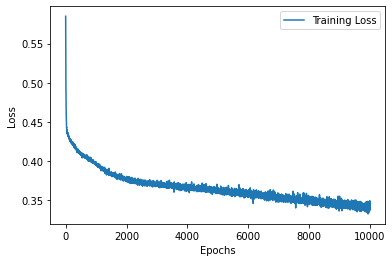

In [196]:
loss_values = history.history['loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

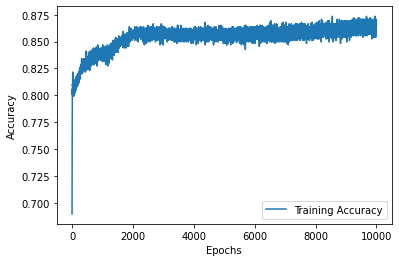

In [197]:
accuracy = history.history['accuracy']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [202]:
y_pred_dev_proba = nn_model.predict(X_dev)
y_pred_dev = (y_pred_dev_proba > 0.5).astype(int).flatten()
y_true_dev = y_dev
target_names = ['class 0', 'class 1']
print(classification_report(y_true_dev, y_pred_dev, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.78      0.88      0.83       106
     class 1       0.78      0.64      0.71        73

    accuracy                           0.78       179
   macro avg       0.78      0.76      0.77       179
weighted avg       0.78      0.78      0.78       179



# 3. Predict Test Set

In [262]:
test_df = pd.read_csv(TEST_PATH)

In [263]:
test_df.shape

(418, 11)

In [264]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [265]:
ids = test_df['PassengerId'].tolist()

In [266]:
test_df = pre_processing(test_df)

In [267]:
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,0.452723,0,0,0.015282,3
1,3,1,0.617566,1,0,0.013663,1
2,2,0,0.815377,0,0,0.018909,3
3,3,0,0.353818,0,0,0.016908,1
4,3,1,0.287881,1,1,0.023984,1


In [268]:
test_df.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [269]:
test_pred = lr_model.predict(test_df)

In [270]:
test_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [271]:
pred_df = pd.DataFrame(columns=['PassengerId', 'Survived'], data=np.transpose(np.asarray([ids, test_pred.tolist()])))

In [272]:
pred_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [273]:
pred_df.shape

(418, 2)

In [274]:
pred_df.to_csv('./predictions.csv', index=False)